In [19]:
import torch
from kornia.geometry.transform import translate, resize
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib as plt

In [81]:
IMG_DIR = '/data/cat/tn/datasets/zero-pose/intra/zero-global_orient/extra/shape-normal/extra/style-normal/extra/256/train/male/t-shirt+pant/rgb/'

img = np.array(Image.open(os.path.join(IMG_DIR, '00000.png')))
img_tensor = torch.from_numpy(img).unsqueeze(0)

In [26]:
def determine_bbox(img):
    x1 = 0
    y1 = 0
    x2 = img.shape[0] - 1
    y2 = img.shape[1] - 1

    for x in range(img.shape[0]):
        if np.any(img[x]):
            x1 = x
            break
            
    for y in range(img.shape[1]):
        if np.any(img[:, y]):
            y1 = y
            break

    for x in range(img.shape[0] - 1, 0, -1):
        if np.any(img[x]):
            x2 = x
            break

    for y in range(img.shape[1] -1, 0, -1):
        if np.any(img[:, y]):
            y2 = y
            break

    bbox = np.array([[x1, y1], [x2, y2]])

    return bbox

## RGB transformation

### NumPy / OpenCV

In [59]:
from utils.image_utils import numpy_scale_retaining_center

ModuleNotFoundError: No module named 'utils'

### Torch / Kornia

In [146]:
center_coords = torch.tensor([img_tensor.shape[1] / 2, img_tensor.shape[2] / 2])

max_value, max_idx = torch.max(bbox[:, 1] - bbox[:, 0], dim=1)
img_size = img_dims[max_idx]
random_fraction = (torch.rand(bbox.shape[0]) * 0.1) + 0.85
subject_size = img_size * random_fraction
scaling_factor = subject_size / max_value

center_offset = center_coords * (scaling_factor - 1)
cropped_img, trans_img, resized_img, orig_img = scale_retaining_center(img_tensor, bbox)

trans_img = trans_img.swapaxes(1, 3)
resized_img = resized_img.swapaxes(1, 3)

Original image:


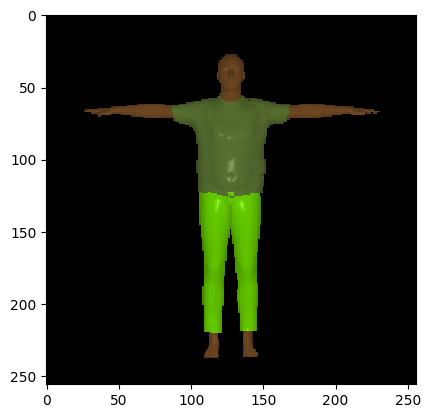

Resized image:


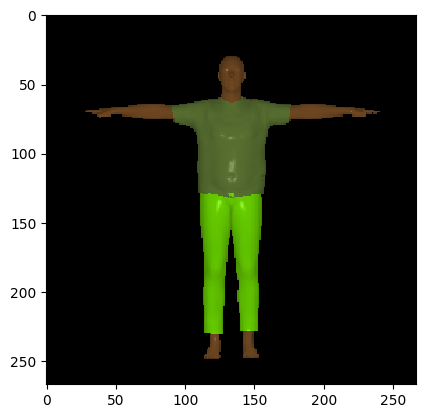

Translated image:


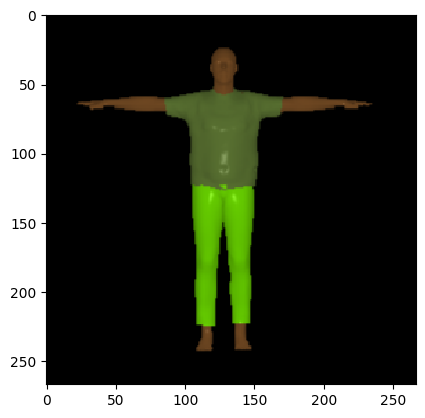

Cropped image (final):


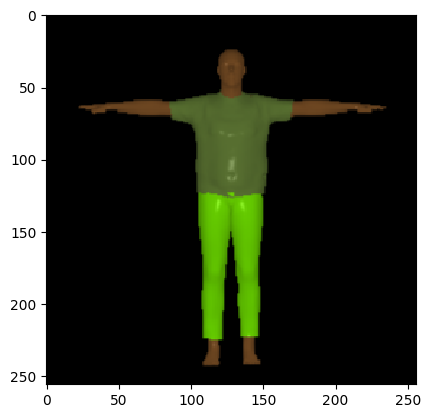

In [149]:
from matplotlib import pyplot as plt
print('Original image:')
plt.imshow(orig_img[0].cpu().detach().numpy() / 255, interpolation='nearest')
plt.show()
print('Resized image:')
plt.imshow(resized_img[0].cpu().detach().numpy() / 255, interpolation='nearest')
plt.show()
print('Translated image:')
plt.imshow(trans_img[0].cpu().detach().numpy() / 255, interpolation='nearest')
plt.show()
print('Cropped image (final):')
plt.imshow(cropped_img[0].cpu().detach().numpy() / 255, interpolation='nearest')
plt.show()

### Note

The final RGB image is somewhat less focused that the original, but this should not effect the model (edges).

## Silhouette transformation

In [9]:
SILH_DIR = '/data/cat/tn/datasets/zero-pose/intra/zero-global_orient/extra/shape-normal/extra/style-normal/extra/256/train/male/t-shirt+pant/segmentations/'

segmaps = np.load(os.path.join(SILH_DIR, '00000.npz'))['seg_maps']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256)
bool
float32


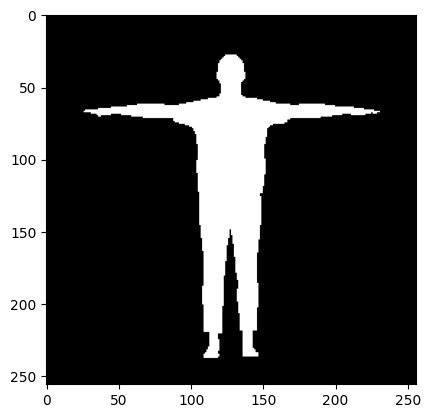

In [25]:
%matplotlib inline
print(segmaps[-1].shape)
print(img['seg_maps'][0].dtype)
np_fullbody_map = np.repeat((segmaps[-1][:, :, None] * 255), 3, axis=2).astype(np.float32)
print(np_fullbody_map.dtype)

plt.imshow(np_fullbody_map)
plt.show()

### NumPy / OpenCV

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 2)
209


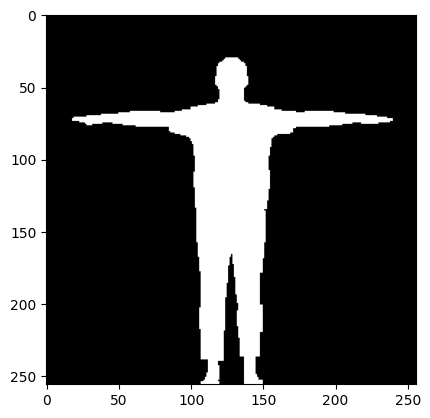

In [55]:
bbox = determine_bbox(np_fullbody_map)
print(bbox.shape)
print(np.max(bbox[1] - bbox[0], axis=0))
cropped_img = numpy_scale_retaining_center(np_fullbody_map, bbox)

plt.imshow(cropped_img)
plt.show()

### Torch / Kornia

In [56]:
SILH_DIR = '/data/cat/tn/datasets/zero-pose/intra/zero-global_orient/extra/shape-normal/extra/style-normal/extra/256/train/male/t-shirt+pant/segmentations/'

segmaps = torch.from_numpy(np.load(os.path.join(SILH_DIR, '00000.npz'))['seg_maps'])

In [58]:
torch_fullbody_map = torch.from_numpy(np.repeat((segmaps[:, -1][None, 0] * 255).detach().cpu().numpy(), 3, axis=0))